### `Extrinsic` Calibration

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
# from pyntcloud import PyntCloud
from mujoco_parser import MuJoCoParserClass
from util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.5]


In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_apriltag.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=False)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_apriltag"))]
# Place objects
xyzs = sample_xyzs(n_sample=1,
                   x_range=[0.6,0.9],y_range=[-0.0,0.0],z_range=[0.81,0.81],min_dist=0.1)

for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

Ready.


IK done.
q_traj's L:[1259] time_max:[2.52]sec


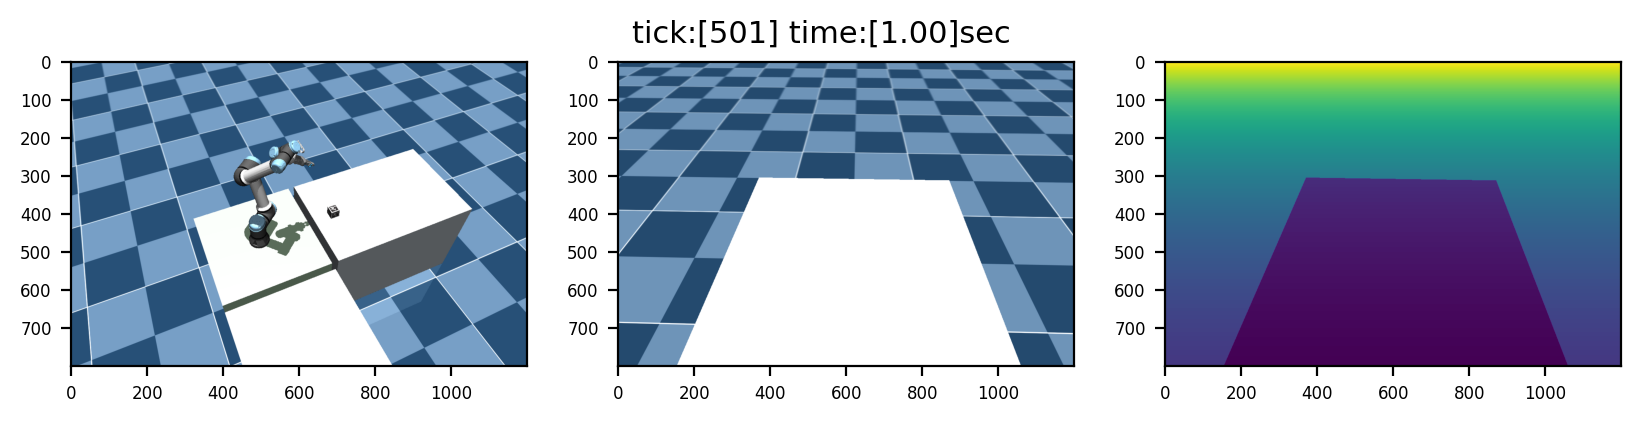

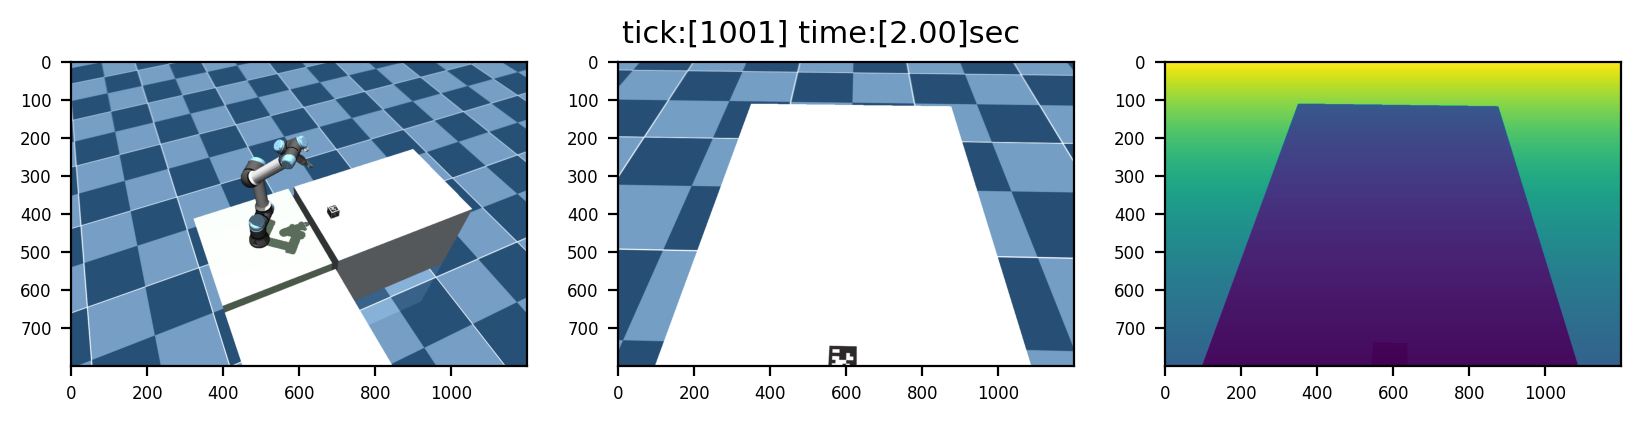

Pressed ESC
Quitting.


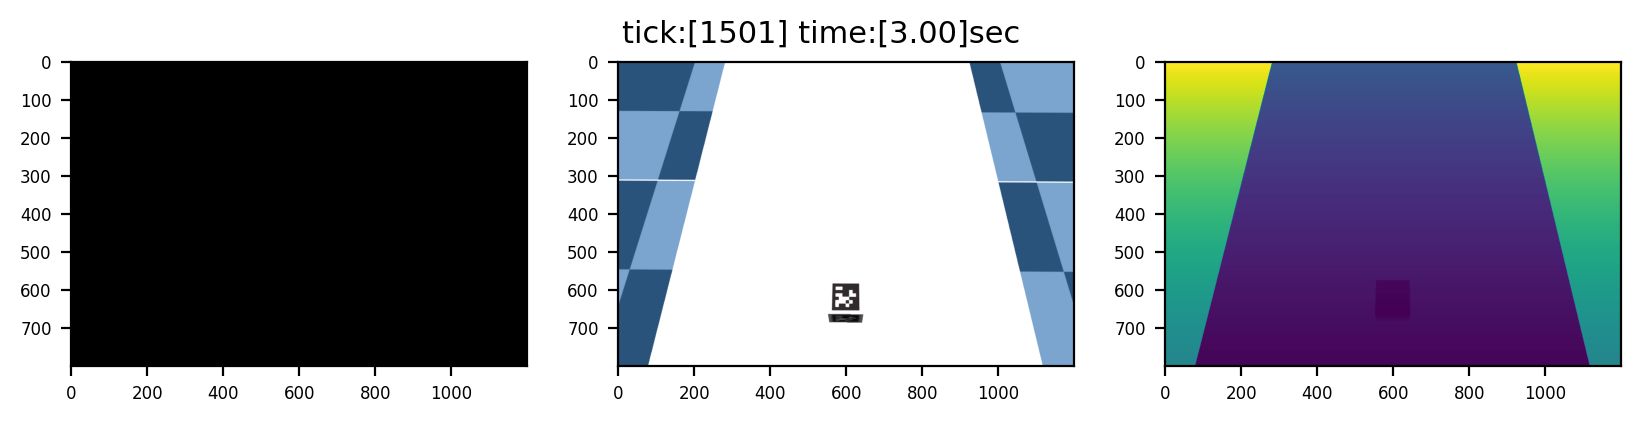

Done. Tick:[1502] Time:[3.00]sec


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = False
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-2)

# 30 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))

pcd_tick = 0

# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=env.idxs_forward)
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    env.step(ctrl=q_traj[tick,:],ctrl_idxs=env.idxs_step)
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,0]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=None,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # Camera intrinsic
        fovy = 45
        img_height = depth_img.shape[0]
        img_width = depth_img.shape[1]
        focal_scaling = 0.5*img_height/np.tan(fovy*np.pi/360)
        cam_matrix = np.array(((focal_scaling,0,img_width/2),
                            (0,focal_scaling,img_height/2),
                            (0,0,1)))

        # Save PCD
        pcd_tick += 1
        np.save('./data/pcd_{:04d}.npy'.format(pcd_tick),pcd)
        env.render(render_every=1)
        
    # Plot
    if env.loop_every(HZ=1):
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.subplots_adjust(wspace=0.2); plt.show()
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

### Get `AX=XB` matrix data

#### Get matrix `A`: Detected AprilTag pose

In [4]:
def draw_bbox(results, image, verbose=False):
    width = 1200
    height = 800

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (255, 0, 0), 3)
        cv2.line(image, ptB, ptC, (255, 0, 0), 3)
        cv2.line(image, ptC, ptD, (255, 0, 0), 3)
        cv2.line(image, ptD, ptA, (255, 0, 0), 3)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose == True:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

In [5]:
import apriltag
import copy

def get_apriltag_pose(img, cam_matrix, img_xyz):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about A that represents detected AprilTag pose in camera coordinate.
    """

    img_copy = copy.deepcopy(img)
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    detector = apriltag.Detector()
    results = detector.detect(img_Gray)

    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    cam_params = [fx, fy, cx, cy]

    # Render the detections on the image
    if len(results) > 0:
        draw_bbox(results, img_copy, verbose=False)
        
        # plt.imshow(img_copy)
        # plt.show()

        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)    # should check tag_size
            
            poseRotation = pose[:3, :3]
            poseTranslation = pose[:3, 3]

            center_point = [int(r.center[i]) for i in reversed(range(2))]    # in int type

            rot_april = pose[:3, :3]
            center_3d = np.array([img_xyz[center_point[0], center_point[1]]])

            T_april = np.concatenate((rot_april, center_3d.T), axis=1)  # 4x3 matrix
            T_april = np.concatenate((T_april, np.array([[0,0,0,1]])), axis=0)  # 4x4 matrix

        return T_april # , img_xyz
    else:   # if any detected marker is none, return None.
        return None

T_april = get_apriltag_pose(rgb_img, cam_matrix, xyz_img)
print(f"AprilTag pose in camera coordinate:\n{T_april}")

AprilTag pose in camera coordinate:
[[ 0.01  1.    0.02  0.74]
 [-0.89  0.    0.45  0.  ]
 [ 0.45 -0.02  0.89 -0.17]
 [ 0.    0.    0.    1.  ]]


### Get matrix `B`: Transformation operations about robot links

In [6]:
def get_homogeneous_matrix(env, from_link='ur_base_link', to_link='camera_center', verbose=False):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about B that represents sequenced transformation operations on ['from link' to 'to link'].
        T^to_from = (T^from_world)^-1 @ T^to_world
    """
    # world coordinate T_from
    p_from = env.get_p_body(body_name=from_link)  # 3x3
    R_from = env.get_R_body(body_name=from_link)  # 3x1
    T_from = cv2.hconcat((R_from, p_from))      # 3x4
    T_from = np.vstack((T_from, np.array([0,0,0,1])))   # 4x4

    # world coordinate T_to
    p_to = env.get_p_body(body_name=to_link)  # 3x3
    R_to = env.get_R_body(body_name=to_link)  # 3x1
    T_to = cv2.hconcat((R_to, p_to))      # 3x4
    T_to = np.vstack((T_to, np.array([0,0,0,1])))   # 4x4
    
    # Homogeneous matrix 'from link' to 'to link'
    p_from_inv = -np.linalg.inv(R_from) @ p_from
    R_from_inv = np.linalg.inv(R_from)
    T_from_inv = cv2.hconcat((R_from_inv, p_from_inv))      # 3x4
    T_from_inv = np.vstack((T_from_inv, np.array([0,0,0,1])))   # 4x4

    T_from2to = T_from_inv @ T_to

    if verbose:
        print(f"Transformation matrix about 'from link': {from_link}")
        print(T_from)
        print(f"Transformation matrix about 'to link': {to_link}")
        print(T_to)
        print(f"Transformation matrix about 'from2to' link: {from_link} -> {to_link}")
        print(T_from2to)

    return T_from2to

bs2ee_matrix = get_homogeneous_matrix(env, from_link='base', to_link='camera_center', verbose=True)

Transformation matrix about 'from link': base
[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.8]
 [0.  0.  0.  1. ]]
Transformation matrix about 'to link': camera_center
[[ 0.49  0.    0.87  0.39]
 [ 0.    1.   -0.   -0.  ]
 [-0.87  0.    0.49  1.6 ]
 [ 0.    0.    0.    1.  ]]
Transformation matrix about 'from2to' link: base -> camera_center
[[ 0.49  0.    0.87  0.39]
 [ 0.    1.   -0.   -0.  ]
 [-0.87  0.    0.49  0.8 ]
 [ 0.    0.    0.    1.  ]]


### Get `Extrinsic` matrix: using A and B matrix

In [7]:
# extrinsic calibration using cv2.calibrateHandEye()
def get_extrinsic_calibration(env, rgb_img, xyz_img, cam_matrix, from_link="camera_center", to_link="ur_base_link", VERBOSE=False):
    # Get matrix A.
    # Transformation matrix about 'camera to target'.
    tagpose = get_apriltag_pose(rgb_img, cam_matrix, xyz_img)
    R_cam2target = tagpose[:3, :3]
    p_cam2target = tagpose[:3, 3]

    # Inverse of T_cam2target
    R_target2cam = np.linalg.inv(R_cam2target)
    p_target2cam = -np.linalg.inv(R_cam2target) @ p_cam2target
    T_target2cam = cv2.hconcat((R_target2cam, p_target2cam))

    # Get matrix B.
    # Transformation matrix about 'ee to base'.
    T_bs2ee = get_homogeneous_matrix(env, from_link=to_link, to_link=from_link, verbose=False)

    T_ee2bs = get_homogeneous_matrix(env, from_link=from_link, to_link=to_link, verbose=False)
    R_ee2bs = T_ee2bs[:3, :3]
    p_ee2bs = T_ee2bs[:3, 3]

    if VERBOSE:
        print("Tagpose: Camera to Target")
        print(tagpose)
        print("Tagpose: Target to Camera")
        print(T_target2cam)
        print("Robot T matrix: Base to E.E.")
        print(T_bs2ee)
        print("Robot T matrix: E.E. to Base")
        print(T_ee2bs)

    return R_ee2bs, p_ee2bs, R_target2cam, p_target2cam


In [8]:
# Create empty lists
R_ee2bs_values = []
p_ee2bs_values = []
R_target2cam_values = []
p_target2cam_values = []


R_ee2bs, p_ee2bs, R_target2cam, p_target2cam= get_extrinsic_calibration(env, rgb_img, xyz_img, cam_matrix, from_link="camera_center", to_link="base", VERBOSE=False)


IK done.
q_traj's L:[1123] time_max:[2.25]sec


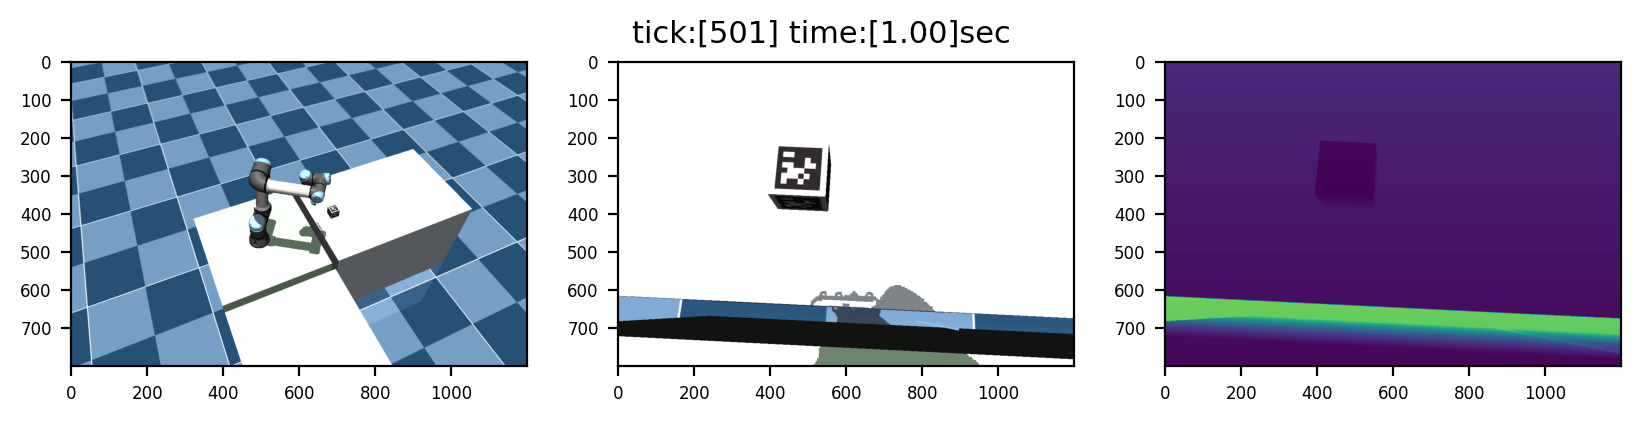

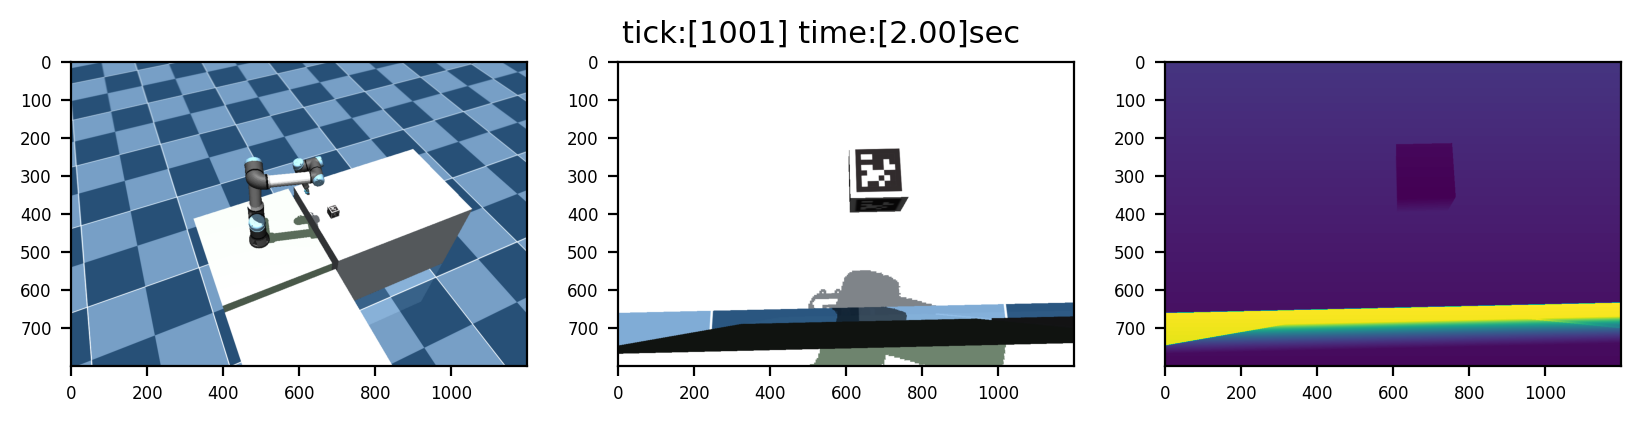

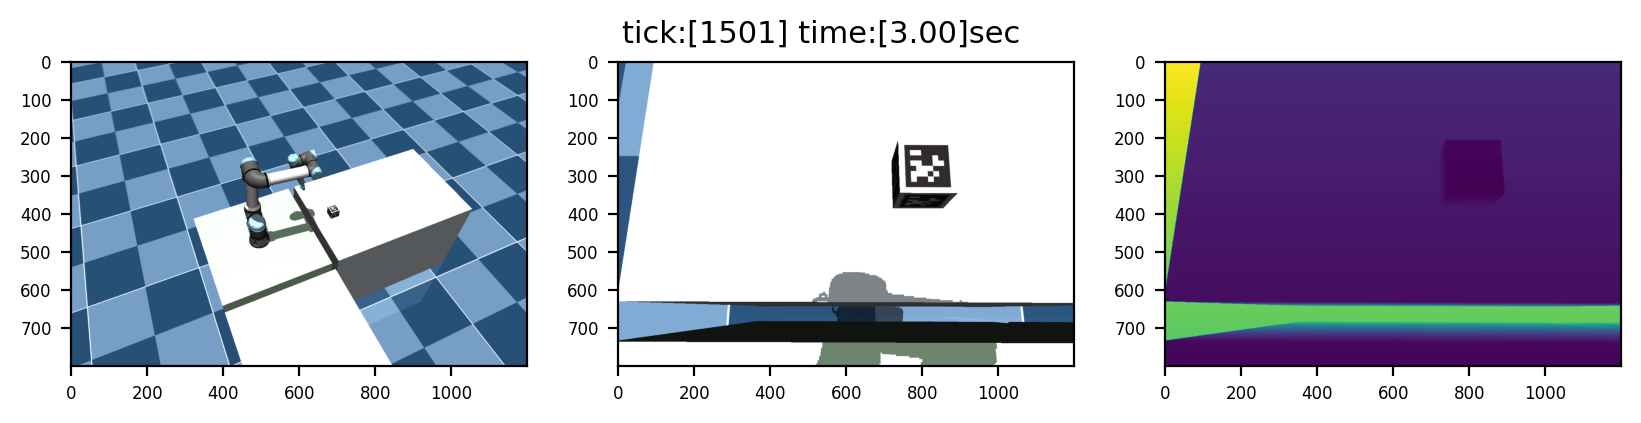

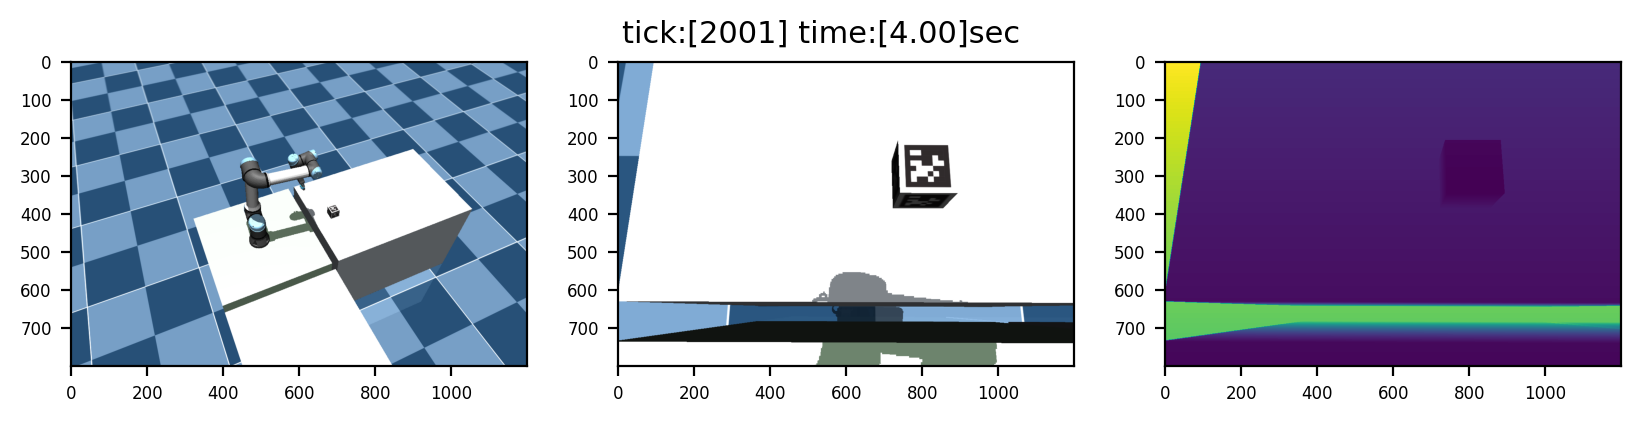

Pressed ESC
Quitting.
Done. Tick:[2227] Time:[4.45]sec


In [15]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

DO_RENDER_IK = True

# 30 deg down pose
p_trgt = p_base + np.array([0.4,-0.1,0.3])
R_trgt = rpy2r(np.radians([0,75,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=10*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0.1,0.3])
R_trgt = rpy2r(np.radians([0,75,0]))@rpy2r(np.radians([-180,0,90]))
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=10*np.pi/180.0,err_th=1e-4)

print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))

pcd_tick = 0

# Create empty lists
R_ee2bs_values = []
p_ee2bs_values = []
R_target2cam_values = []
p_target2cam_values = []


# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=env.idxs_forward)
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    env.step(ctrl=q_traj[tick,:],ctrl_idxs=env.idxs_step)
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,0]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=None,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # Camera intrinsic
        fovy = 45
        img_height = depth_img.shape[0]
        img_width = depth_img.shape[1]
        focal_scaling = 0.5*img_height/np.tan(fovy*np.pi/360)
        cam_matrix = np.array(((focal_scaling,0,img_width/2),
                            (0,focal_scaling,img_height/2),
                            (0,0,1)))

        # insert in dictionary
        R_ee2bs, p_ee2bs, R_target2cam, p_target2cam= get_extrinsic_calibration(env, rgb_img, xyz_img, cam_matrix, from_link="camera_center", to_link="base", VERBOSE=False)
        R_ee2bs_values.append(R_ee2bs)
        p_ee2bs_values.append(p_ee2bs)
        R_target2cam_values.append(R_target2cam)
        p_target2cam_values.append(p_target2cam)

        # Save PCD
        pcd_tick += 1
        env.render(render_every=1)
        
    # Plot
    if env.loop_every(HZ=1):
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.subplots_adjust(wspace=0.2); plt.show()
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

In [16]:
# Get Extrinsic offset btw 'camera to ee.'
R_ext, p_ext = cv2.calibrateHandEye(R_ee2bs_values, p_ee2bs_values, R_target2cam_values, p_target2cam_values, method=cv2.CALIB_HAND_EYE_TSAI)
T_extrinsic = cv2.hconcat((R_ext, p_ext))      # 3x4
T_extrinsic = np.vstack((T_extrinsic, np.array([0,0,0,1])))   # 4x4
print("Robot T matrix: Camera to E.E.")
print(T_extrinsic)

Robot T matrix: Camera to E.E.
[[ 0.78 -0.51 -0.36  0.18]
 [ 0.49  0.86 -0.15  0.37]
 [ 0.39 -0.06  0.92 -2.64]
 [ 0.    0.    0.    1.  ]]


In [17]:
# Ground truth
p_gt = env.get_p_body('camera_center') - env.get_p_body('tcp_link')
R_gt = env.get_R_body('camera_center') @ env.get_R_body('tcp_link').T

In [18]:
p_gt, R_gt

(array([ 0.04, -0.  ,  0.2 ]),
 array([[-0.94,  0.25, -0.24],
        [ 0.25,  0.  , -0.97],
        [-0.24, -0.97, -0.06]]))